# Импорт библиотек

In [1]:
import sys
print(sys.executable)
print(sys.version)

c:\Users\Smart\PycharmProjects\MLOPS_Ksusha\clean_mlops\Scripts\python.exe
3.11.5 (tags/v3.11.5:cce6ba9, Aug 24 2023, 14:38:34) [MSC v.1936 64 bit (AMD64)]


Установить нужные библиотеки 

Поменять пути надо будет на свои

`C:\Users\Smart\PycharmProjects\MLOPS_Ksusha\clean_mlops\Scripts\python.exe -m pip install -r C:\Users\Smart\PycharmProjects\MLOPS_Ksusha\requirements.txt`

In [2]:
# Стандартные библиотеки
import re
import time
from functools import lru_cache
from collections import Counter
import warnings

# Для работы с данными и визуализации
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Для работы с машинным обучением (классические модели)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score


# Для обработки текста
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from tqdm import tqdm

# TensorFlow / Keras (для LSTM, CNN и других нейронных сетей)
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Embedding, LSTM, Dense, Dropout, SpatialDropout1D,
    Conv1D, GlobalMaxPooling1D, Concatenate, Input
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Transformers / Hugging Face
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    pipeline
)

# Настройки
warnings.filterwarnings('ignore')

# Загрузка nltk ресурсов
for resource in ['punkt', 'stopwords', 'wordnet']:
    try:
        nltk.data.find(f'tokenizers/{resource}' if resource=='punkt' else f'corpora/{resource}')
    except LookupError:
        nltk.download(resource)


import mlflow
from mlflow import MlflowClient
from omegaconf import OmegaConf
import os

import joblib
import mlflow.keras

from datasets import Dataset
import json
import pickle

c:\Users\Smart\PycharmProjects\MLOPS_Ksusha\clean_mlops\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Smart\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Запуск MLFLOW server

`mlflow server --port 8080 --host 127.0.0.1`



In [3]:
mlflow.set_tracking_uri('http://localhost:8080')

# Настройка параметризации

In [4]:
# Загрузка конфигурации
def load_config(config_name):
    config_path = f"config/{config_name}.yml"
    
    if not os.path.exists(config_path):
        raise FileNotFoundError(f"Конфигурационный файл {config_path} не найден")
    
    cfg = OmegaConf.load(config_path)
    
    if 'MLFLOW_TRACKING_URI' in os.environ:
        cfg.mlflow.tracking_uri = os.environ['MLFLOW_TRACKING_URI']
    
    return cfg

# Эксперименты с датасетами

## 1 эксперимент (Чистые данные)

Размер датасета: (416809, 2)

Первые 3 строки:
                                                text  label
0      i just feel really helpless and heavy hearted      4
1  ive enjoyed being able to slouch about relax a...      0
2  i gave up my internship with the dmrg and am f...      4

Распределение классов:
label
1    141067
0    121187
3     57317
4     47712
2     34554
5     14972
Name: count, dtype: int64


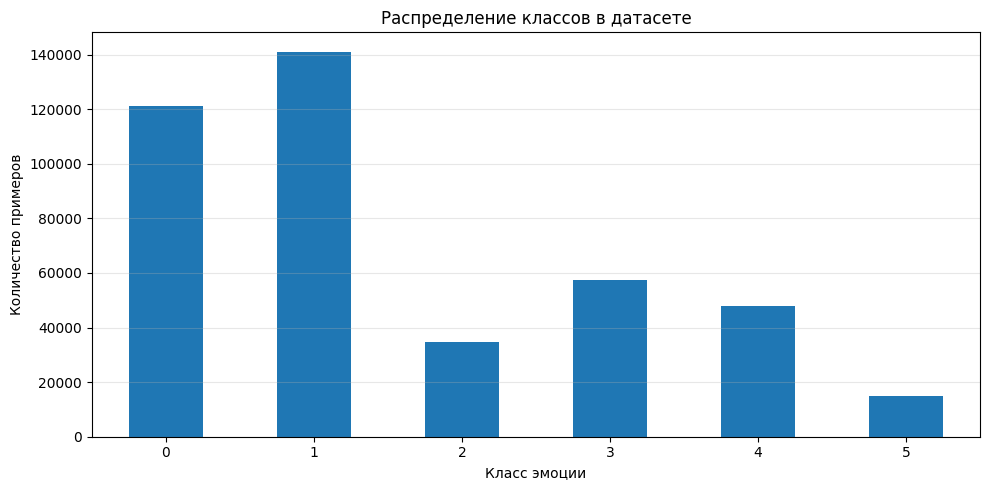

In [5]:
# Загружаем конфиг
cfg = load_config("first_dataset_experiment")

# Настройка MLflow
mlflow.set_tracking_uri(cfg.mlflow.tracking_uri)
mlflow.set_experiment(experiment_id=cfg.mlflow.experiment_name)

# Старт run с параметрами из конфига
with mlflow.start_run(run_name=cfg.mlflow.run_name):
    
    # Устанавливаем все теги из конфига
    for tag_key, tag_value in cfg.mlflow.tags.items():
        mlflow.set_tag(tag_key, tag_value)
    
    # Загрузка данных с параметрами из конфига
    df = pd.read_csv(
        cfg.data.input.path,
        sep=cfg.data.input.delimiter,
        encoding=cfg.data.input.encoding
    )
    
    # Получаем названия колонок из конфига
    text_column = cfg.data.input.columns.text
    label_column = cfg.data.input.columns.label
    
    print(f"Размер датасета: {df.shape}")
    print(f"\nПервые 3 строки:")
    print(df.head(3))
    print(f"\nРаспределение классов:")
    print(df[label_column].value_counts())
    
    # Визуализация распределения классов
    plt.figure(figsize=(10, 5))
    df[label_column].value_counts().sort_index().plot(kind='bar')
    plt.title('Распределение классов в датасете')
    plt.xlabel('Класс эмоции')
    plt.ylabel('Количество примеров')
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    
    # Сохраняем визуализацию
    viz_filename = 'class_distribution.png'
    plt.savefig(viz_filename)
    plt.show()
    
    # Логирование артефактов
    mlflow.log_artifact(cfg.data.input.path, 'data')
    mlflow.log_artifact(viz_filename, 'viz')
    
    # Сохранение обработанных данных (если нужно)
    if cfg.data.output.save_processed:
        if cfg.data.output.include_original:
            df.to_csv(cfg.data.output.path, index=False)
        else:
            # Можно добавить препроцессинг здесь
            df[[text_column, label_column]].to_csv(cfg.data.output.path, index=False)
        
        # Логируем обработанные данные
        mlflow.log_artifact(cfg.data.output.path, 'data')
 
    
    # Логируем метрики (распределение классов)
    class_distribution = df[label_column].value_counts().to_dict()
    for class_label, count in class_distribution.items():
        mlflow.log_metric(f"class_{class_label}_count", count)

## 2 эксперимент (Очистка + Лемматизация)

In [6]:
from tqdm import tqdm
tqdm.pandas()

# Загружаем конфиг
cfg = load_config("second_dataset_experiment")

# Настройка MLflow
mlflow.set_tracking_uri(cfg.mlflow.tracking_uri)
mlflow.set_experiment(experiment_id=cfg.mlflow.experiment_name)

# Старт run с параметрами из конфига
with mlflow.start_run(run_name=cfg.mlflow.run_name):
    
    print(f"🚀 Начинаю препроцессинг датасета...")
    
    # Загрузка данных
    print(f"📥 Загружаю данные из {cfg.data.input.path}")
    df = pd.read_csv(
        cfg.data.input.path,
        sep=cfg.data.input.delimiter,
        encoding=cfg.data.input.encoding
    )
    print(f"✅ Загружено {len(df)} строк")
    
    # Инициализация компонентов препроцессинга
    lemmatizer = WordNetLemmatizer()
    
    # Настройка стоп-слов
    stop_words = set(stopwords.words(cfg.preprocessing.stopwords.language))
    if cfg.preprocessing.stopwords.important_words:
        important_words = set(cfg.preprocessing.stopwords.important_words)
        stop_words = stop_words - important_words
    
    # Кэшированная функция лемматизации
    @lru_cache(maxsize=cfg.preprocessing.lemmatizer.cache_size)
    def lemmatization(word):
        for pos in cfg.preprocessing.lemmatizer.pos_tags:
            lemmatized = lemmatizer.lemmatize(word, pos=pos)
            if lemmatized != word:
                return lemmatized
        return lemmatizer.lemmatize(word)
    
    # Функция препроцессинга
    def preprocess_text(text, remove_stopwords=None, lemmatize=None):
        if remove_stopwords is None:
            remove_stopwords = cfg.preprocessing.remove_stopwords
        if lemmatize is None:
            lemmatize = cfg.preprocessing.lemmatize
        
        text = str(text)
        
        if cfg.preprocessing.lowercase:
            text = text.lower()
        
        text = text.strip()
        
        if cfg.preprocessing.remove_punctuation or cfg.preprocessing.remove_numbers:
            pattern = ''
            if cfg.preprocessing.remove_punctuation:
                pattern += r'[^a-z\s]'
            if cfg.preprocessing.remove_numbers:
                pattern += r'\d'
            if pattern:
                text = re.sub(pattern, ' ', text)
        
        if cfg.preprocessing.remove_extra_spaces:
            text = re.sub(r'\s+', ' ', text)
        
        if cfg.preprocessing.tokenization:
            tokens = nltk.word_tokenize(text)
        else:
            tokens = text.split()
        
        if (remove_stopwords or lemmatize or cfg.preprocessing.remove_short_words):
            processed_tokens = []
            for token in tokens:
                if cfg.preprocessing.remove_short_words and len(token) <= cfg.preprocessing.min_word_length:
                    continue
                
                if remove_stopwords and token in stop_words:
                    continue
                
                if lemmatize:
                    token = lemmatization(token)
                
                processed_tokens.append(token)
            
            return ' '.join(processed_tokens)
        
        return ' '.join(tokens)
    
    # Применяем препроцессинг с прогресс-баром
    print(f"🔄 Применяю препроцессинг...")
    df[cfg.preprocessing.new_column] = df[cfg.preprocessing.text_column].progress_apply(preprocess_text)
    
    # Сохранение ОБРАБОТАННЫХ данных БЕЗ дублирования
    if cfg.data.output.include_original:
        # Сохраняем все колонки (оригинальные + обработанные)
        processed_df = df
        print(f"💾 Сохраняю все колонки (с оригинальным текстом)")
    else:
        # Сохраняем ТОЛЬКО обработанный текст и метки
        processed_df = df[[cfg.preprocessing.new_column, cfg.data.input.columns.label]]
        # Переименовываем для удобства
        processed_df = processed_df.rename(columns={
            cfg.preprocessing.new_column: 'processed_text',
            cfg.data.input.columns.label: 'label'
        })
        print(f"💾 Сохраняю только обработанный текст и метки")
    
    processed_df.to_csv(cfg.data.output.path, index=False)
    
    # Логируем только датасет
    print(f"📤 Логирую в MLflow...")
    mlflow.log_artifact(cfg.data.output.path, 'data')
    
    print(f"✅ Препроцессинг завершен!")
    print(f"   📊 Исходный датасет: {df.shape[0]} строк, {df.shape[1]} колонок")
    print(f"   💾 Сохранен как: {cfg.data.output.path}")
    print(f"   🗂️  Колонки: {list(processed_df.columns)}")

🚀 Начинаю препроцессинг датасета...
📥 Загружаю данные из Датасет_курсовая.csv
✅ Загружено 416809 строк
🔄 Применяю препроцессинг...


100%|██████████| 416809/416809 [15:23<00:00, 451.29it/s]


💾 Сохраняю все колонки (с оригинальным текстом)
📤 Логирую в MLflow...
✅ Препроцессинг завершен!
   📊 Исходный датасет: 416809 строк, 3 колонок
   💾 Сохранен как: Dataset_2.csv
   🗂️  Колонки: ['text', 'label', 'processed_text']


# Эксперименты с моделями

## 1 эксперимент -- Наивный Байес

In [7]:
cfg = load_config("nb_experiment")

with mlflow.start_run(run_name='first_model_experiment'):

    mlflow.set_tag('NaiveBayes', cfg.model.version)

    # =====================================================================================================================================
    #                                         СЧИТЫВАНИЕ ДАТАСЕТА ИЗ Second_dataset_experiment
    # =====================================================================================================================================

    client = MlflowClient()

    # Ищем run с препроцессированными данными
    dataset_runs = client.search_runs(
        experiment_ids=[cfg.mlflow.experiment_id],
        filter_string="tags.mlflow.runName = 'Second_dataset_experiment'",
        order_by=['attributes.end_time desc']
    )

    if not dataset_runs:
        raise ValueError("Run 'Second_dataset_experiment' не найден")

    second_dataset_run = dataset_runs[0]
    second_dataset_run_id = second_dataset_run.info.run_id

    print(f"✓ Найден run: Second_dataset_experiment")
    print(f"✓ Run ID: {second_dataset_run_id}")

    # ПРАВИЛЬНЫЙ ПУТЬ К АРТЕФАКТУ
    artifact_path = "data/Dataset_2.csv"
    
    print(f"Загружаю: {artifact_path}")
    dataframe_path = client.download_artifacts(second_dataset_run_id, artifact_path)
    df = pd.read_csv(dataframe_path)
    
    print(f"✅ Успешно загружен: {artifact_path}")

    # Проверяем структуру датасета
    print("\n" + "="*60)
    print("ИНФОРМАЦИЯ О ЗАГРУЖЕННОМ ДАТАСЕТЕ")
    print("="*60)
    print(f"Размер: {df.shape[0]} строк, {df.shape[1]} столбцов")
    print(f"Колонки: {list(df.columns)}")
    
    # Проверяем наличие NaN значений
    print(f"\n🔍 Проверка NaN значений:")
    print(f"   text: {df['text'].isna().sum()} NaN")
    print(f"   label: {df['label'].isna().sum()} NaN")
    print(f"   processed_text: {df['processed_text'].isna().sum()} NaN")
    
    # Проверяем наличие нужных колонок и переименовываем
    if 'processed_text' in df.columns:
        df = df.rename(columns={'processed_text': cfg.data.text_column_name})
        print(f"Переименовал 'processed_text' в '{cfg.data.text_column_name}'")
    elif 'text' in df.columns:
        df = df.rename(columns={'text': cfg.data.text_column_name})
        print(f"Переименовал 'text' в '{cfg.data.text_column_name}'")
    
    if 'label' in df.columns:
        print(f"Колонка меток: 'label'")
    elif 'emotion' in df.columns:
        df = df.rename(columns={'emotion': cfg.data.label_column_name})
        print(f"Переименовал 'emotion' в '{cfg.data.label_column_name}'")
    else:
        raise ValueError(f"Не найдена колонка с метками. Доступные: {list(df.columns)}")

    # ОЧИСТКА ДАННЫХ - УДАЛЯЕМ NaN
    initial_rows = len(df)
    df = df.dropna(subset=[cfg.data.text_column_name, cfg.data.label_column_name])
    df = df.reset_index(drop=True)
    
    print(f"\n🧹 Очистка данных:")
    print(f"   Удалено строк с NaN: {initial_rows - len(df)}")
    print(f"   Осталось строк: {len(df)}")
    
    # Проверяем, что после переименования колонки существуют
    print(f"\n✅ Финальные колонки: {list(df.columns)}")
    print(f"   Текстовая колонка: '{cfg.data.text_column_name}'")
    print(f"   Метка: '{cfg.data.label_column_name}'")
    
    # Проверяем типы данных
    print(f"\n📊 Типы данных:")
    print(f"   {cfg.data.text_column_name}: {df[cfg.data.text_column_name].dtype}")
    print(f"   {cfg.data.label_column_name}: {df[cfg.data.label_column_name].dtype}")
    
    # Преобразуем текст в строки (на всякий случай)
    df[cfg.data.text_column_name] = df[cfg.data.text_column_name].astype(str)
    
    display(df.head())

    # =====================================================================================================================================
    #                                              ВЕКТОРИЗАЦИЯ ТЕКСТА
    # =====================================================================================================================================

    vectorizer = TfidfVectorizer(
        lowercase=True,
        analyzer='word',
        max_features=cfg.vectorizer.max_features,
        ngram_range=tuple(cfg.vectorizer.ngram_range),
        min_df=cfg.vectorizer.min_df,
        max_df=cfg.vectorizer.max_df
    )
    
    encoder = LabelEncoder()

    # =====================================================================================================================================
    #                                         РАЗБИЕНИЕ НА TRAIN/TEST
    # =====================================================================================================================================

    print(f"\n🎯 Разделение данных:")
    print(f"   Тестовая выборка: {cfg.training.test_size*100}%")
    print(f"   Random state: {cfg.training.random_state}")
    print(f"   Стратификация: Да")
    
    df_train, df_test = train_test_split(
        df, 
        test_size=cfg.training.test_size, 
        random_state=cfg.training.random_state, 
        stratify=df[cfg.data.label_column_name]
    )
    
    print(f"   Train: {len(df_train):,} строк")
    print(f"   Test: {len(df_test):,} строк")

    X_train = df_train[cfg.data.text_column_name]
    print(f"\n🔄 Векторизация текста...")
    X_train = vectorizer.fit_transform(X_train)
    print(f"   Размерность признаков: {X_train.shape[1]}")

    y_train = df_train[cfg.data.label_column_name]
    y_train = encoder.fit_transform(y_train)

    X_test = df_test[cfg.data.text_column_name]
    X_test = vectorizer.transform(X_test)

    y_test = df_test[cfg.data.label_column_name]
    y_test = encoder.transform(y_test)

    # =====================================================================================================================================
    #                                         ОБУЧЕНИЕ И ЛОГИРОВАНИЕ МОДЕЛИ
    # =====================================================================================================================================

    mlflow.sklearn.autolog(disable=True)
    
    model = MultinomialNB()
    
    print(f"\n🤖 Обучение модели...")
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)

    print(f'✅ f1-score: {f1:.4f}')
    print(f'✅ accuracy: {accuracy:.4f}')

    joblib.dump(model, cfg.model.model_file)
    joblib.dump(vectorizer, cfg.model.vectorizer_file)
    joblib.dump(encoder, cfg.model.encoder_file)
    
    mlflow.log_artifact(cfg.model.model_file, 'models')
    mlflow.log_artifact(cfg.model.vectorizer_file, 'models')
    mlflow.log_artifact(cfg.model.encoder_file, 'models')
    
    mlflow.log_metrics({
        'f1_score': f1,
        'accuracy': accuracy
    })


    print("\n✅ Модель успешно обучена и залогирована!")

✓ Найден run: Second_dataset_experiment
✓ Run ID: 326cc404377243a4b22b4ec9116d9f2a
Загружаю: data/Dataset_2.csv


✅ Успешно загружен: data/Dataset_2.csv

ИНФОРМАЦИЯ О ЗАГРУЖЕННОМ ДАТАСЕТЕ
Размер: 416809 строк, 3 столбцов
Колонки: ['text', 'label', 'processed_text']

🔍 Проверка NaN значений:
   text: 0 NaN
   label: 0 NaN
   processed_text: 15 NaN
Переименовал 'processed_text' в 'span'
Колонка меток: 'label'

🧹 Очистка данных:
   Удалено строк с NaN: 15
   Осталось строк: 416794

✅ Финальные колонки: ['text', 'label', 'span']
   Текстовая колонка: 'span'
   Метка: 'label'

📊 Типы данных:
   span: object
   label: int64


,text,label,span
0,i just feel really helpless and heavy hearted,4,feel really helpless heavy hearted
1,ive enjoyed being able to slouch about relax a...,0,ive enjoy able slouch relax unwind frankly nee...
2,i gave up my internship with the dmrg and am f...,4,give internship dmrg feel distraught
3,i dont know i feel so lost,0,dont know feel lose
4,i am a kindergarten teacher and i am thoroughl...,4,kindergarten teacher thoroughly weary job take...



🎯 Разделение данных:
   Тестовая выборка: 20.0%
   Random state: 42
   Стратификация: Да
   Train: 333,435 строк
   Test: 83,359 строк

🔄 Векторизация текста...
   Размерность признаков: 5000

🤖 Обучение модели...
✅ f1-score: 0.8570
✅ accuracy: 0.8646

✅ Модель успешно обучена и залогирована!


## 2 эксперимент -- CNN (TensorFlow)

CNN ДЛЯ КЛАССИФИКАЦИИ ЭМОЦИЙ

[1/6] Загрузка данных...


✓ Загружено: 416,809 примеров
✓ Время: 24.65 сек

[2/6] Подготовка данных...
✓ Очищено от NaN: 15 строк

Распределение классов:
  neutral: 121,183 примеров
  joy: 141,065 примеров
  sadness:  34,554 примеров
  anger:  57,311 примеров
  fear:  47,709 примеров
  surprise:  14,972 примеров

[3/6] Токенизация...
✓ Train: 333,435 примеров
✓ Test:  83,359 примеров
✓ Словарь: 5000 слов
✓ Длина последовательности: 50

[4/6] Создание модели CNN...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 64)            320000    
                                                                 
 conv1d (Conv1D)             (None, 48, 64)            12352     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
       

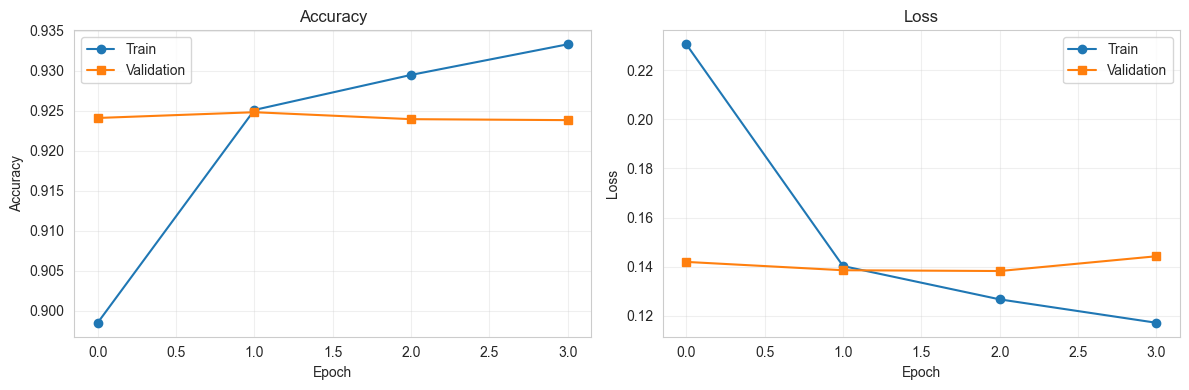

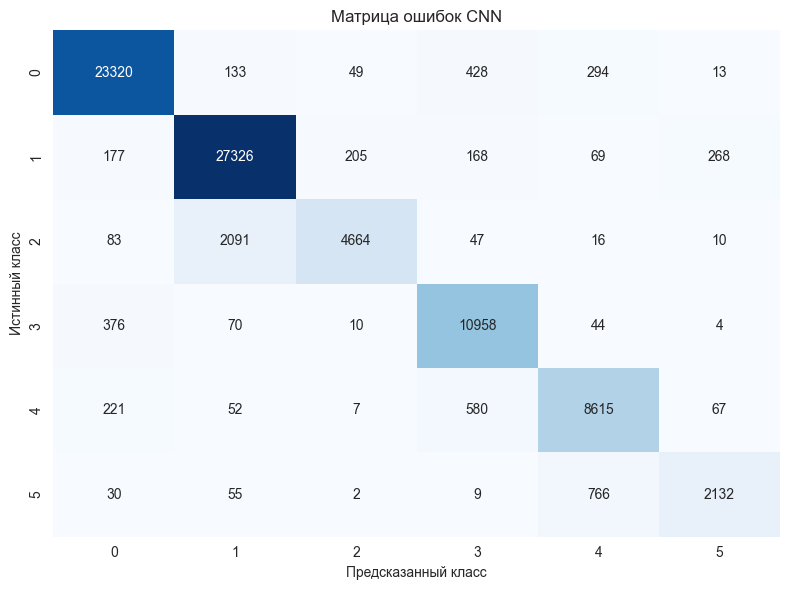


Отчет по классам:
              precision    recall  f1-score   support

           0      0.963     0.962     0.963     24237
           1      0.919     0.969     0.943     28213
           2      0.945     0.675     0.787      6911
           3      0.899     0.956     0.927     11462
           4      0.879     0.903     0.891      9542
           5      0.855     0.712     0.777      2994

    accuracy                          0.924     83359
   macro avg      0.910     0.863     0.881     83359
weighted avg      0.924     0.924     0.922     83359

✓ Модель сохранена локально: cnn_model.h5
✓ Токенизатор сохранен: tokenizer.pickle
✓ Конфигурация сохранена: model_config.json

CNN МОДЕЛЬ ОБУЧЕНА И ЗАЛОГИРОВАНА
✓ Accuracy: 0.9239
✓ F1 Macro: 0.8813
✓ Модель сохранена в MLflow


In [8]:
# Загружаем конфиг
cfg = load_config("cnn_experiment")

# Настройка MLflow
mlflow.set_tracking_uri(cfg.mlflow.tracking_uri)
mlflow.set_experiment(experiment_id=cfg.mlflow.experiment_id)

# Настройки визуализации
plt.style.use('default')
sns.set_style("whitegrid")

# Старт run
with mlflow.start_run(run_name=cfg.mlflow.run_name):
    
    # Устанавливаем теги
    for tag_key, tag_value in cfg.mlflow.tags.items():
        mlflow.set_tag(tag_key, tag_value)
    
    print("=" * 60)
    print("CNN ДЛЯ КЛАССИФИКАЦИИ ЭМОЦИЙ")
    print("=" * 60)
    
    # =====================================================================
    # 1. ЗАГРУЗКА ДАННЫХ
    # =====================================================================
    print("\n[1/6] Загрузка данных...")
    start_time = time.time()
    
    client = MlflowClient()
    
    # Ищем run с данными
    dataset_runs = client.search_runs(
        experiment_ids=[cfg.mlflow.experiment_id],
        filter_string="tags.mlflow.runName = 'Second_dataset_experiment'",
        order_by=['attributes.end_time desc']
    )
    
    if not dataset_runs:
        raise ValueError("Run 'Second_dataset_experiment' не найден")
    
    dataset_run = dataset_runs[0]
    dataset_run_id = dataset_run.info.run_id
    
    # Загружаем датасет
    artifact_path = cfg.data.artifact_path
    dataframe_path = client.download_artifacts(dataset_run_id, artifact_path)
    df = pd.read_csv(dataframe_path)
    
    print(f"✓ Загружено: {df.shape[0]:,} примеров")
    print(f"✓ Время: {time.time() - start_time:.2f} сек")
    
    # Логируем источник данных
    mlflow.log_params({
        'data_source': 'Second_dataset_experiment',
        'data_run_id': dataset_run_id
    })
    
    # =====================================================================
    # 2. ПОДГОТОВКА ДАННЫХ
    # =====================================================================
    print("\n[2/6] Подготовка данных...")
    
    # Проверяем колонки
    if 'processed_text' in df.columns and cfg.data.text_column not in df.columns:
        df = df.rename(columns={'processed_text': cfg.data.text_column})
    
    # Очистка NaN
    if cfg.preprocessing.clean_nan:
        initial_rows = len(df)
        df = df.dropna(subset=[cfg.data.text_column, cfg.data.label_column])
        df = df.reset_index(drop=True)
        print(f"✓ Очищено от NaN: {initial_rows - len(df)} строк")
    
    # Распределение классов
    labels_count = df[cfg.data.label_column].value_counts()
    print("\nРаспределение классов:")
    for label in sorted(labels_count.index):
        class_name = cfg.class_names.get(int(label), label)
        print(f"  {class_name}: {labels_count[label]:>7,} примеров")
    
    # Логируем распределение
    for label, count in labels_count.items():
        mlflow.log_metric(f"class_{label}_count", int(count))
    
    # =====================================================================
    # 3. ТОКЕНИЗАЦИЯ
    # =====================================================================
    print("\n[3/6] Токенизация...")
    
    X = df[cfg.data.text_column]
    y = df[cfg.data.label_column]
    
    # Разделение
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=cfg.training.test_size, 
        random_state=cfg.training.random_state, 
        stratify=y
    )
    
    print(f"✓ Train: {len(X_train):,} примеров")
    print(f"✓ Test:  {len(X_test):,} примеров")
    
    # Токенизация
    tokenizer = Tokenizer(num_words=cfg.preprocessing.vocab_size)
    tokenizer.fit_on_texts(X_train)
    
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)
    
    X_train_pad = pad_sequences(X_train_seq, maxlen=cfg.preprocessing.max_length, padding=cfg.preprocessing.padding)
    X_test_pad = pad_sequences(X_test_seq, maxlen=cfg.preprocessing.max_length, padding=cfg.preprocessing.padding)
    
    print(f"✓ Словарь: {cfg.preprocessing.vocab_size} слов")
    print(f"✓ Длина последовательности: {cfg.preprocessing.max_length}")
    
    # =====================================================================
    # 4. СОЗДАНИЕ МОДЕЛИ
    # =====================================================================
    print("\n[4/6] Создание модели CNN...")
    
    num_classes = len(np.unique(y))
    
    model = Sequential([
        Embedding(cfg.preprocessing.vocab_size, cfg.model.embedding_dim, input_length=cfg.preprocessing.max_length),
        Conv1D(cfg.model.conv_filters, cfg.model.conv_kernel_size, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(cfg.model.dense_units, activation='relu'),
        Dropout(cfg.model.dropout_rate),
        Dense(num_classes, activation='softmax')
    ])
    
    # ИСПРАВЛЕНИЕ: Преобразуем ListConfig в обычный список
    metrics_list = list(cfg.model.metrics) if hasattr(cfg.model.metrics, '__iter__') else ['accuracy']
    
    model.compile(
        optimizer=cfg.model.optimizer,
        loss=cfg.model.loss,
        metrics=metrics_list  # Используем преобразованный список
    )
    
    # Краткий summary
    model.summary()
    
    # Логируем параметры модели
    mlflow.log_params({
        'vocab_size': cfg.preprocessing.vocab_size,
        'max_length': cfg.preprocessing.max_length,
        'embedding_dim': cfg.model.embedding_dim,
        'conv_filters': cfg.model.conv_filters,
        'conv_kernel_size': cfg.model.conv_kernel_size,
        'dense_units': cfg.model.dense_units,
        'dropout_rate': cfg.model.dropout_rate,
        'num_classes': num_classes
    })
    
    # =====================================================================
    # 5. ОБУЧЕНИЕ
    # =====================================================================
    print("\n[5/6] Обучение модели...")
    
    early_stop = EarlyStopping(
        monitor=cfg.training.early_stopping.monitor,
        patience=cfg.training.early_stopping.patience,
        restore_best_weights=cfg.training.early_stopping.restore_best_weights
    )
    
    history = model.fit(
        X_train_pad, y_train,
        validation_split=cfg.training.validation_split,
        epochs=cfg.training.epochs,
        batch_size=cfg.training.batch_size,
        callbacks=[early_stop],
        verbose=1
    )
    
    # Логируем историю обучения
    for epoch in range(len(history.history['accuracy'])):
        mlflow.log_metric('train_accuracy', history.history['accuracy'][epoch], step=epoch)
        mlflow.log_metric('val_accuracy', history.history['val_accuracy'][epoch], step=epoch)
    
    # =====================================================================
    # 6. ОЦЕНКА
    # =====================================================================
    print("\n[6/6] Оценка модели...")
    
    # Предсказания
    y_pred_proba = model.predict(X_test_pad, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    # Метрики
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    
    print("\n" + "="*50)
    print("РЕЗУЛЬТАТЫ")
    print("="*50)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Macro: {f1:.4f}")
    
    # Логируем финальные метрики
    mlflow.log_metrics({
        'accuracy': accuracy,
        'f1_score': f1
    })
    
    # Визуализация обучения
    if cfg.visualization.plot_history:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        ax1.plot(history.history['accuracy'], label='Train', marker='o')
        ax1.plot(history.history['val_accuracy'], label='Validation', marker='s')
        ax1.set_title('Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        ax2.plot(history.history['loss'], label='Train', marker='o')
        ax2.plot(history.history['val_loss'], label='Validation', marker='s')
        ax2.set_title('Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig("training_history.png")
        plt.show()
        mlflow.log_artifact("training_history.png", "viz")
    
    # Матрица ошибок
    if cfg.visualization.plot_confusion:
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title('Матрица ошибок CNN')
        plt.xlabel('Предсказанный класс')
        plt.ylabel('Истинный класс')
        plt.tight_layout()
        plt.savefig("confusion_matrix.png")
        plt.show()
        mlflow.log_artifact("confusion_matrix.png", "viz")
    
    # Отчет по классам
    print("\nОтчет по классам:")
    print(classification_report(y_test, y_pred, digits=3))
    
    # =====================================================================
    # СОХРАНЕНИЕ МОДЕЛИ И ТОКЕНИЗАТОРА
    # =====================================================================
    
    # 1. Сохраняем модель в формате H5 (более совместимый)
    model.save("cnn_model.h5", save_format='h5')
    print(f"✓ Модель сохранена локально: cnn_model.h5")
    
    # 2. Логируем как артефакт в MLflow
    mlflow.log_artifact("cnn_model.h5", "models")
    
    # 3. Сохраняем токенизатор
    with open("tokenizer.pickle", 'wb') as f:
        pickle.dump(tokenizer, f)
    print(f"✓ Токенизатор сохранен: tokenizer.pickle")
    
    # 4. Логируем токенизатор в MLflow
    mlflow.log_artifact("tokenizer.pickle", "models")
    
    # 5. Сохраняем конфигурацию модели для воспроизводимости
    model_config = {
        'vocab_size': cfg.preprocessing.vocab_size,
        'max_length': cfg.preprocessing.max_length,
        'embedding_dim': cfg.model.embedding_dim,
        'num_classes': num_classes,
        'class_names': dict(cfg.class_names),
        'padding': cfg.preprocessing.padding
    }
    
    with open("model_config.json", 'w') as f:
        json.dump(model_config, f, indent=2)
    mlflow.log_artifact("model_config.json", "models")
    print(f"✓ Конфигурация сохранена: model_config.json")
    
    print("\n" + "="*50)
    print("CNN МОДЕЛЬ ОБУЧЕНА И ЗАЛОГИРОВАНА")
    print("="*50)
    print(f"✓ Accuracy: {accuracy:.4f}")
    print(f"✓ F1 Macro: {f1:.4f}")
    print(f"✓ Модель сохранена в MLflow")

## 3 эксперимент -- Трансформеры

In [5]:
# ======================
# УПРОЩЕННАЯ TRANSFORMER МОДЕЛЬ
# ======================

# Загружаем конфиг
cfg = load_config("transformer_experiment")

# Настройка MLflow
mlflow.set_tracking_uri(cfg.mlflow.tracking_uri)
mlflow.set_experiment(experiment_id=cfg.mlflow.experiment_id)

# Старт run
with mlflow.start_run(run_name=cfg.mlflow.run_name):
    
    # Устанавливаем теги
    for tag_key, tag_value in cfg.mlflow.tags.items():
        mlflow.set_tag(tag_key, tag_value)
    
    print("=" * 60)
    print("TRANSFORMER МОДЕЛЬ ДЛЯ КЛАССИФИКАЦИИ ЭМОЦИЙ")
    print("=" * 60)
    
    # =====================================================================
    # 1. ЗАГРУЗКА И ПОДГОТОВКА ДАННЫХ
    # =====================================================================
    print("\n[1/5] Загрузка и подготовка данных...")
    start_time = time.time()
    
    # Загружаем датасет из MLflow
    client = MlflowClient()
    
    # Ищем run с данными
    dataset_runs = client.search_runs(
        experiment_ids=[cfg.mlflow.experiment_id],
        filter_string="tags.mlflow.runName = 'Second_dataset_experiment'",
        order_by=['attributes.end_time desc']
    )
    
    if not dataset_runs:
        raise ValueError("Run 'Second_dataset_experiment' не найден")
    
    dataset_run = dataset_runs[0]
    dataset_run_id = dataset_run.info.run_id
    
    # Загружаем датасет
    artifact_path = cfg.data.artifact_path
    dataframe_path = client.download_artifacts(dataset_run_id, artifact_path)
    df = pd.read_csv(dataframe_path)
    
    print(f"✓ Загружено: {df.shape[0]:,} примеров")
    print(f"✓ Колонки: {list(df.columns)}")
    
    # =====================================================================
    # ВАЖНО: Убираем дублирование колонок
    # =====================================================================
    print(f"\n🔍 Проверяю дублирование колонок...")
    
    # Проверяем дубликаты
    duplicate_cols = df.columns[df.columns.duplicated()].tolist()
    if duplicate_cols:
        print(f"⚠️  Найдены дубликаты: {duplicate_cols}")
        # Убираем дубликаты
        df = df.loc[:, ~df.columns.duplicated()]
        print(f"✓ Убрал дубликаты колонок")
    
    # Смотрим какие колонки у нас есть
    print(f"✓ Уникальные колонки: {list(df.columns)}")
    
    # Определяем текстовую колонку
    if 'processed_text' in df.columns:
        # Переименовываем processed_text в text
        df = df.rename(columns={'processed_text': 'text'})
        print(f"✓ Использую 'processed_text' как текстовую колонку")
    elif 'text' in df.columns:
        print(f"✓ Использую существующую колонку 'text'")
    else:
        # Ищем другую текстовую колонку
        for col in df.columns:
            if col != 'label' and df[col].dtype == 'object':
                df = df.rename(columns={col: 'text'})
                print(f"✓ Использую '{col}' как текстовую колонку")
                break
    
    # Определяем колонку меток
    if 'label' in df.columns:
        print(f"✓ Использую существующую колонку 'label'")
    else:
        # Ищем колонку с метками
        for col in df.columns:
            if col != 'text' and df[col].dtype in ['int64', 'int32', 'float64']:
                df = df.rename(columns={col: 'label'})
                print(f"✓ Использую '{col}' как колонку меток")
                break
    
    # Убираем лишние колонки, оставляем только text и label
    print(f"\n🧹 Очищаю датасет...")
    keep_columns = ['text', 'label']
    
    # Проверяем что нужные колонки есть
    missing_cols = [col for col in keep_columns if col not in df.columns]
    if missing_cols:
        print(f"❌ Отсутствуют колонки: {missing_cols}")
        print(f"   Доступные колонки: {list(df.columns)}")
        raise ValueError(f"Нет колонок {missing_cols}")
    
    # Оставляем только нужные колонки
    df = df[['text', 'label']].copy()
    print(f"✓ Оставил только колонки: {list(df.columns)}")
    
    # Проверяем дубликаты еще раз
    if df.columns.duplicated().any():
        print(f"⚠️  Все еще есть дубликаты, исправляю...")
        df = df.loc[:, ~df.columns.duplicated()]
    
    print(f"✓ Финальные колонки: {list(df.columns)}")
    print(f"✓ Тип text: {df['text'].dtype}")
    print(f"✓ Тип label: {df['label'].dtype}")
    
    # Балансировка классов
    print(f"\n⚖️  Балансировка классов...")
    df = df.groupby('label').apply(lambda x: x.sample(n=10000, random_state=42)).reset_index(drop=True)
    print(f"✓ Сбалансировано: {len(df):,} примеров")
    
    # Распределение классов
    labels_count = df['label'].value_counts()
    print("\n📊 Распределение классов:")
    for label in sorted(labels_count.index):
        print(f"  Класс {label}: {labels_count[label]:>7,} примеров")
    
    # Логируем распределение классов
    for label, count in labels_count.items():
        mlflow.log_metric(f"class_{label}_count", int(count))
    
    # Логируем информацию о данных
    mlflow.log_params({
        'data_source': 'Second_dataset_experiment',
        'data_run_id': dataset_run_id,
        'total_samples': len(df),
        'num_classes': len(labels_count)
    })
    
    print(f"✓ Время подготовки: {time.time() - start_time:.2f} сек")
    
    # =====================================================================
    # 2. РАЗДЕЛЕНИЕ ДАННЫХ
    # =====================================================================
    print("\n[2/5] Разделение данных на train/val/test...")
    
    # Разделение на train/test/validation
    df_train, df_temp = train_test_split(
        df, 
        test_size=cfg.data.split.test_size, 
        random_state=cfg.data.split.random_state,
        stratify=df['label']
    )
    
    df_val, df_test = train_test_split(
        df_temp, 
        test_size=cfg.data.split.val_size, 
        random_state=cfg.data.split.random_state,
        stratify=df_temp['label']
    )
    
    print(f"✓ Train: {len(df_train):,} примеров")
    print(f"✓ Val:   {len(df_val):,} примеров")
    print(f"✓ Test:  {len(df_test):,} примеров")
    
    # Проверяем что нет дубликатов колонок
    print(f"\n🔍 Финальная проверка колонок:")
    print(f"  df_train колонки: {list(df_train.columns)}")
    print(f"  df_val колонки: {list(df_val.columns)}")
    print(f"  df_test колонки: {list(df_test.columns)}")
    
    # Конвертация в формат Dataset
    print(f"\n🔄 Конвертация в Dataset...")
    train_dataset = Dataset.from_pandas(df_train)
    val_dataset = Dataset.from_pandas(df_val)
    test_dataset = Dataset.from_pandas(df_test)
    
    print(f"✓ Datasets созданы")
    print(f"  train_dataset колонки: {train_dataset.column_names}")
    
    # =====================================================================
    # 3. ТОКЕНИЗАЦИЯ
    # =====================================================================
    print(f"\n[3/5] Загрузка модели и токенизатора...")
    print(f"  Модель: {cfg.model.name}")

    # Загружаем токенизатор
    tokenizer = AutoTokenizer.from_pretrained(cfg.model.name)

    print("\n[+] Токенизация данных...")

    def tokenize_function(examples):
        """Функция токенизации"""
        texts = examples['text']  # Используем фиксированное имя колонки
        
        if not isinstance(texts, list):
            texts = [str(text) for text in texts]
        
        texts = [str(text) for text in texts]
        texts = [text for text in texts if text and text != 'nan' and str(text).lower() != 'nan']
        
        return tokenizer(
            texts, 
            truncation=cfg.model.tokenizer.truncation,
            max_length=cfg.model.tokenizer.max_length, 
            padding=cfg.model.tokenizer.padding
        )

    # Проверяем перед токенизацией
    print(f"  Проверяю данные...")
    print(f"  Первый текст: {train_dataset[0]['text'][:50]}...")
    print(f"  Первая метка: {train_dataset[0]['label']}")
    
    # Токенизация
    tokenized_train = train_dataset.map(tokenize_function, batched=True)
    tokenized_val = val_dataset.map(tokenize_function, batched=True)
    tokenized_test = test_dataset.map(tokenize_function, batched=True)

    print(f"✓ Токенизация завершена")
    print(f"✓ Максимальная длина: {cfg.model.tokenizer.max_length}")

    # =====================================================================
    # 4. ПОДГОТОВКА МОДЕЛИ И ОБУЧЕНИЕ
    # =====================================================================
    print(f"\n[4/5] Подготовка модели...")
    
    # Определяем количество классов
    num_classes = len(df['label'].unique())
    
    # Загружаем модель
    model = AutoModelForSequenceClassification.from_pretrained(
        cfg.model.name,
        num_labels=num_classes
    )
    
    # Логируем параметры модели
    mlflow.log_params({
        'model_name': cfg.model.name,
        'num_labels': num_classes,
        'max_length': cfg.model.tokenizer.max_length
    })
    
    # Функция вычисления метрик
    def compute_metrics(eval_pred):
        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=1)
        
        # Вычисляем метрики
        accuracy = accuracy_score(labels, predictions)
        f1 = f1_score(labels, predictions, average='weighted')
        
        return {
            'accuracy': accuracy,
            'f1_weighted': f1
        }
    
    # Настройка параметров обучения
    training_args = TrainingArguments(
        output_dir=cfg.training.output_dir,
        num_train_epochs=cfg.training.num_train_epochs,
        per_device_train_batch_size=cfg.training.per_device_train_batch_size,
        per_device_eval_batch_size=cfg.training.per_device_eval_batch_size,
        warmup_ratio=cfg.training.warmup_ratio,
        weight_decay=cfg.training.weight_decay,
        evaluation_strategy=cfg.training.eval_strategy,
        save_strategy=cfg.training.save_strategy,
        load_best_model_at_end=True,
        metric_for_best_model="f1_weighted",  # Теперь эта метрика будет вычисляться
        greater_is_better=True,
        save_total_limit=2,
        report_to="none",
        logging_steps=50,  # Добавляем логирование каждые 50 шагов
    )
    
    # Создание Trainer
    print("\n" + "=" * 60)
    print("НАЧИНАЕМ ОБУЧЕНИЕ МОДЕЛИ")
    print("=" * 60)
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,  # Добавляем функцию вычисления метрик
        data_collator=DataCollatorWithPadding(tokenizer=tokenizer)
    )
    
    # Обучение модели
    train_start_time = time.time()
    trainer.train()
    training_time = time.time() - train_start_time
    
    print(f"✓ Обучение завершено за {training_time:.2f} сек")
    
    # Логируем время обучения
    mlflow.log_metric('training_time_seconds', training_time)
    
    # =====================================================================
    # 5. ОЦЕНКА И СОХРАНЕНИЕ
    # =====================================================================
    print("\n[5/5] Оценка модели...")
    
    # Делаем предсказания на тестовом наборе
    test_predictions = trainer.predict(tokenized_test)
    test_preds = np.argmax(test_predictions.predictions, axis=1)
    test_labels = test_predictions.label_ids
    
    # Вычисляем метрики
    test_f1 = f1_score(test_labels, test_preds, average="weighted")
    test_accuracy = accuracy_score(test_labels, test_preds)
    
    print(f"\n📊 РЕЗУЛЬТАТЫ НА ТЕСТОВОМ НАБОРЕ:")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"F1 Score: {test_f1:.4f}")
    
    # Логируем метрики
    mlflow.log_metric("f1_score", test_f1)
    mlflow.log_metric("accuracy", test_accuracy)
    
    # Отчет по классам
    print("\n📋 Отчет по классам (тестовый набор):")
    print(classification_report(test_labels, test_preds, digits=3))
    
    # Получаем метрики с валидационного набора
    eval_results = trainer.evaluate()
    print(f"\n📊 РЕЗУЛЬТАТЫ НА ВАЛИДАЦИОННОМ НАБОРЕ:")
    print(f"Validation Accuracy: {eval_results.get('eval_accuracy', 0):.4f}")
    print(f"Validation F1: {eval_results.get('eval_f1_weighted', 0):.4f}")
    
    # Логируем валидационные метрики
    mlflow.log_metrics({
        'val_accuracy': eval_results.get('eval_accuracy', 0),
        'val_f1_score': eval_results.get('eval_f1_weighted', 0)
    })
    
    # =====================================================================
    # 6. СОХРАНЕНИЕ МОДЕЛИ (точно как в курсаче)
    # =====================================================================
    print(f"\n💾 Сохранение модели...")
    
    # СОХРАНЕНИЕ
    model_dir = "best_transformer_model"
    tokenizer_dir = "best_transformer_tokenizer"

    # Сохраняем модель и токенизатор
    trainer.save_model(model_dir)
    tokenizer.save_pretrained(tokenizer_dir)

    print(f"✓ Модель сохранена в папку: {model_dir}")
    print(f"✓ Токенизатор сохранен в папку: {tokenizer_dir}")

    # Проверяем что файлы созданы
    print("\n🔍 Проверяю сохраненные файлы...")
    if os.path.exists(model_dir):
        model_files = os.listdir(model_dir)
        print(f"Файлы в модели ({len(model_files)}):")
        for file in model_files:
            print(f"  - {file}")
    else:
        print("❌ Папка модели не создана!")

    if os.path.exists(tokenizer_dir):
        tokenizer_files = os.listdir(tokenizer_dir)
        print(f"Файлы в токенизаторе ({len(tokenizer_files)}):")
        for file in tokenizer_files:
            print(f"  - {file}")
    else:
        print("❌ Папка токенизатора не создана!")

    # Логируем артефакты в MLflow
    print("\n📤 Логирую артефакты в MLflow...")
    try:
        mlflow.log_artifacts(model_dir, artifact_path="model")
        print("✓ Модель залогирована")
    except Exception as e:
        print(f"❌ Ошибка при логировании модели: {e}")
        # Пробуем логировать по одному файлу
        for file in os.listdir(model_dir):
            try:
                file_path = os.path.join(model_dir, file)
                mlflow.log_artifact(file_path, artifact_path="model")
                print(f"✓ Файл {file} залогирован")
            except Exception as e2:
                print(f"❌ Ошибка при логировании файла {file}: {e2}")

    try:
        mlflow.log_artifacts(tokenizer_dir, artifact_path="tokenizer")
        print("✓ Токенизатор залогирован")
    except Exception as e:
        print(f"❌ Ошибка при логировании токенизатора: {e}")
        # Пробуем логировать по одному файлу
        for file in os.listdir(tokenizer_dir):
            try:
                file_path = os.path.join(tokenizer_dir, file)
                mlflow.log_artifact(file_path, artifact_path="tokenizer")
                print(f"✓ Файл {file} залогирован")
            except Exception as e2:
                print(f"❌ Ошибка при логировании файла {file}: {e2}")

    # Сохраняем информацию о классах
    import pickle
    class_info = {
        'num_classes': num_classes,
        'class_distribution': labels_count.to_dict(),
        'label_names': sorted(df['label'].unique())
    }
    
    with open('label_info.pkl', 'wb') as f:
        pickle.dump(class_info, f)
    
    try:
        mlflow.log_artifact('label_info.pkl', artifact_path="preprocessing")
        print("✓ Информация о классах залогирована")
    except Exception as e:
        print(f"❌ Ошибка при логировании информации о классах: {e}")

    # Очищаем временные файлы
    import shutil
    import os
    
    # Удаляем временные папки
    print("\n🧹 Очищаю временные файлы...")
    try:
        shutil.rmtree(model_dir, ignore_errors=True)
        print("✓ Папка модели удалена")
    except Exception as e:
        print(f"❌ Ошибка при удалении папки модели: {e}")

    try:
        shutil.rmtree(tokenizer_dir, ignore_errors=True)
        print("✓ Папка токенизатора удалена")
    except Exception as e:
        print(f"❌ Ошибка при удалении папки токенизатора: {e}")

    # Удаляем временный файл
    try:
        if os.path.exists('label_info.pkl'):
            os.remove('label_info.pkl')
            print("✓ Файл label_info.pkl удален")
    except Exception as e:
        print(f"❌ Ошибка при удалении файла label_info.pkl: {e}")



TRANSFORMER МОДЕЛЬ ДЛЯ КЛАССИФИКАЦИИ ЭМОЦИЙ

[1/5] Загрузка и подготовка данных...


✓ Загружено: 416,809 примеров
✓ Колонки: ['text', 'label', 'processed_text']

🔍 Проверяю дублирование колонок...
✓ Уникальные колонки: ['text', 'label', 'processed_text']
✓ Использую 'processed_text' как текстовую колонку
✓ Использую существующую колонку 'label'

🧹 Очищаю датасет...
✓ Оставил только колонки: ['text', 'text', 'label']
⚠️  Все еще есть дубликаты, исправляю...
✓ Финальные колонки: ['text', 'label']
✓ Тип text: object
✓ Тип label: int64

⚖️  Балансировка классов...
✓ Сбалансировано: 60,000 примеров

📊 Распределение классов:
  Класс 0:  10,000 примеров
  Класс 1:  10,000 примеров
  Класс 2:  10,000 примеров
  Класс 3:  10,000 примеров
  Класс 4:  10,000 примеров
  Класс 5:  10,000 примеров
✓ Время подготовки: 10.87 сек

[2/5] Разделение данных на train/val/test...
✓ Train: 42,000 примеров
✓ Val:   9,000 примеров
✓ Test:  9,000 примеров

🔍 Финальная проверка колонок:
  df_train колонки: ['text', 'label']
  df_val колонки: ['text', 'label']
  df_test колонки: ['text', 'label'

Map: 100%|██████████| 9000/9000 [00:01<00:00, 5017.62 examples/s]


✓ Токенизация завершена
✓ Максимальная длина: 128

[4/5] Подготовка модели...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/xtremedistil-l6-h256-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



НАЧИНАЕМ ОБУЧЕНИЕ МОДЕЛИ


  2%|▏         | 50/2625 [01:16<1:05:40,  1.53s/it]

{'loss': 1.791, 'learning_rate': 9.505703422053232e-06, 'epoch': 0.02}


  4%|▍         | 100/2625 [02:32<1:02:35,  1.49s/it]

{'loss': 1.7873, 'learning_rate': 1.9011406844106464e-05, 'epoch': 0.04}


  6%|▌         | 150/2625 [03:45<1:01:45,  1.50s/it]

{'loss': 1.7529, 'learning_rate': 2.8517110266159696e-05, 'epoch': 0.06}


  8%|▊         | 200/2625 [04:58<59:19,  1.47s/it]  

{'loss': 1.6369, 'learning_rate': 3.802281368821293e-05, 'epoch': 0.08}


 10%|▉         | 250/2625 [06:11<59:39,  1.51s/it]  

{'loss': 1.555, 'learning_rate': 4.7528517110266163e-05, 'epoch': 0.1}


 11%|█▏        | 300/2625 [07:26<56:52,  1.47s/it]  

{'loss': 1.4688, 'learning_rate': 4.921676545300593e-05, 'epoch': 0.11}


 13%|█▎        | 350/2625 [08:46<58:31,  1.54s/it]  

{'loss': 1.3556, 'learning_rate': 4.815834038950043e-05, 'epoch': 0.13}


 15%|█▌        | 400/2625 [10:04<58:02,  1.57s/it]  

{'loss': 1.3197, 'learning_rate': 4.709991532599492e-05, 'epoch': 0.15}


 17%|█▋        | 450/2625 [11:25<1:01:14,  1.69s/it]

{'loss': 1.2412, 'learning_rate': 4.6041490262489414e-05, 'epoch': 0.17}


 19%|█▉        | 500/2625 [12:39<55:12,  1.56s/it]  

{'loss': 1.1755, 'learning_rate': 4.498306519898391e-05, 'epoch': 0.19}


 21%|██        | 550/2625 [13:54<51:21,  1.48s/it]

{'loss': 1.1303, 'learning_rate': 4.392464013547841e-05, 'epoch': 0.21}


 23%|██▎       | 600/2625 [15:12<56:14,  1.67s/it]

{'loss': 1.0814, 'learning_rate': 4.2866215071972905e-05, 'epoch': 0.23}


 25%|██▍       | 650/2625 [16:36<51:42,  1.57s/it]

{'loss': 1.0309, 'learning_rate': 4.1807790008467405e-05, 'epoch': 0.25}


 27%|██▋       | 700/2625 [17:47<45:37,  1.42s/it]

{'loss': 1.0164, 'learning_rate': 4.07493649449619e-05, 'epoch': 0.27}


 29%|██▊       | 750/2625 [18:58<44:23,  1.42s/it]

{'loss': 0.9466, 'learning_rate': 3.9690939881456396e-05, 'epoch': 0.29}


 30%|███       | 800/2625 [20:07<43:46,  1.44s/it]

{'loss': 0.8625, 'learning_rate': 3.8632514817950896e-05, 'epoch': 0.3}


 32%|███▏      | 850/2625 [21:19<43:07,  1.46s/it]

{'loss': 0.8559, 'learning_rate': 3.757408975444539e-05, 'epoch': 0.32}


 34%|███▍      | 900/2625 [22:29<40:39,  1.41s/it]

{'loss': 0.8251, 'learning_rate': 3.651566469093988e-05, 'epoch': 0.34}


 36%|███▌      | 950/2625 [23:40<39:06,  1.40s/it]

{'loss': 0.7923, 'learning_rate': 3.545723962743438e-05, 'epoch': 0.36}


 38%|███▊      | 1000/2625 [24:50<37:07,  1.37s/it]

{'loss': 0.7422, 'learning_rate': 3.439881456392888e-05, 'epoch': 0.38}


 40%|████      | 1050/2625 [26:02<35:12,  1.34s/it]

{'loss': 0.7262, 'learning_rate': 3.334038950042337e-05, 'epoch': 0.4}


 42%|████▏     | 1100/2625 [27:12<35:14,  1.39s/it]

{'loss': 0.6815, 'learning_rate': 3.2281964436917865e-05, 'epoch': 0.42}


 44%|████▍     | 1150/2625 [28:32<36:03,  1.47s/it]

{'loss': 0.668, 'learning_rate': 3.1223539373412364e-05, 'epoch': 0.44}


 46%|████▌     | 1200/2625 [29:41<31:48,  1.34s/it]

{'loss': 0.5962, 'learning_rate': 3.016511430990686e-05, 'epoch': 0.46}


 48%|████▊     | 1250/2625 [31:04<40:32,  1.77s/it]

{'loss': 0.6336, 'learning_rate': 2.910668924640136e-05, 'epoch': 0.48}


 50%|████▉     | 1300/2625 [32:40<40:56,  1.85s/it]

{'loss': 0.5983, 'learning_rate': 2.8048264182895852e-05, 'epoch': 0.5}


 51%|█████▏    | 1350/2625 [34:09<38:37,  1.82s/it]

{'loss': 0.5665, 'learning_rate': 2.6989839119390348e-05, 'epoch': 0.51}


 53%|█████▎    | 1400/2625 [35:49<38:31,  1.89s/it]

{'loss': 0.5638, 'learning_rate': 2.5931414055884844e-05, 'epoch': 0.53}


 55%|█████▌    | 1450/2625 [37:21<38:09,  1.95s/it]

{'loss': 0.5369, 'learning_rate': 2.487298899237934e-05, 'epoch': 0.55}


 57%|█████▋    | 1500/2625 [38:59<34:00,  1.81s/it]

{'loss': 0.5797, 'learning_rate': 2.3814563928873836e-05, 'epoch': 0.57}


 59%|█████▉    | 1550/2625 [40:33<35:07,  1.96s/it]

{'loss': 0.5066, 'learning_rate': 2.2756138865368335e-05, 'epoch': 0.59}


 61%|██████    | 1600/2625 [41:46<23:18,  1.36s/it]

{'loss': 0.4946, 'learning_rate': 2.1697713801862828e-05, 'epoch': 0.61}


 63%|██████▎   | 1650/2625 [43:00<25:15,  1.55s/it]

{'loss': 0.437, 'learning_rate': 2.0639288738357327e-05, 'epoch': 0.63}


 65%|██████▍   | 1700/2625 [44:17<22:48,  1.48s/it]

{'loss': 0.4505, 'learning_rate': 1.958086367485182e-05, 'epoch': 0.65}


 67%|██████▋   | 1750/2625 [45:31<23:21,  1.60s/it]

{'loss': 0.4315, 'learning_rate': 1.852243861134632e-05, 'epoch': 0.67}


 69%|██████▊   | 1800/2625 [46:47<19:36,  1.43s/it]

{'loss': 0.4028, 'learning_rate': 1.746401354784081e-05, 'epoch': 0.69}


 70%|███████   | 1850/2625 [47:58<18:46,  1.45s/it]

{'loss': 0.4408, 'learning_rate': 1.640558848433531e-05, 'epoch': 0.7}


 72%|███████▏  | 1900/2625 [49:13<18:03,  1.49s/it]

{'loss': 0.4373, 'learning_rate': 1.5347163420829804e-05, 'epoch': 0.72}


 74%|███████▍  | 1950/2625 [50:26<17:16,  1.53s/it]

{'loss': 0.4643, 'learning_rate': 1.4288738357324303e-05, 'epoch': 0.74}


 76%|███████▌  | 2000/2625 [51:45<15:03,  1.45s/it]

{'loss': 0.4231, 'learning_rate': 1.3230313293818799e-05, 'epoch': 0.76}


 78%|███████▊  | 2050/2625 [52:56<15:00,  1.57s/it]

{'loss': 0.4313, 'learning_rate': 1.2171888230313295e-05, 'epoch': 0.78}


 80%|████████  | 2100/2625 [54:16<13:38,  1.56s/it]

{'loss': 0.3777, 'learning_rate': 1.111346316680779e-05, 'epoch': 0.8}


 82%|████████▏ | 2150/2625 [55:29<11:20,  1.43s/it]

{'loss': 0.3979, 'learning_rate': 1.0055038103302287e-05, 'epoch': 0.82}


 84%|████████▍ | 2200/2625 [56:50<10:16,  1.45s/it]

{'loss': 0.3872, 'learning_rate': 8.996613039796783e-06, 'epoch': 0.84}


 86%|████████▌ | 2250/2625 [58:02<08:57,  1.43s/it]

{'loss': 0.4022, 'learning_rate': 7.93818797629128e-06, 'epoch': 0.86}


 88%|████████▊ | 2300/2625 [59:19<08:10,  1.51s/it]

{'loss': 0.4106, 'learning_rate': 6.8797629127857754e-06, 'epoch': 0.88}


 90%|████████▉ | 2350/2625 [1:00:29<06:25,  1.40s/it]

{'loss': 0.4216, 'learning_rate': 5.821337849280271e-06, 'epoch': 0.9}


 91%|█████████▏| 2400/2625 [1:01:50<05:59,  1.60s/it]

{'loss': 0.3919, 'learning_rate': 4.762912785774767e-06, 'epoch': 0.91}


 93%|█████████▎| 2450/2625 [1:03:02<04:11,  1.44s/it]

{'loss': 0.4122, 'learning_rate': 3.7044877222692633e-06, 'epoch': 0.93}


 95%|█████████▌| 2500/2625 [1:04:20<03:07,  1.50s/it]

{'loss': 0.4152, 'learning_rate': 2.6460626587637597e-06, 'epoch': 0.95}


 97%|█████████▋| 2550/2625 [1:05:34<01:55,  1.54s/it]

{'loss': 0.3821, 'learning_rate': 1.5876375952582556e-06, 'epoch': 0.97}


 99%|█████████▉| 2600/2625 [1:06:51<00:35,  1.41s/it]

{'loss': 0.3916, 'learning_rate': 5.292125317527519e-07, 'epoch': 0.99}


                                                     
100%|██████████| 2625/2625 [1:13:07<00:00,  1.52s/it]

{'eval_loss': 0.31828996539115906, 'eval_accuracy': 0.9197777777777778, 'eval_f1_weighted': 0.9192619575260392, 'eval_runtime': 338.6927, 'eval_samples_per_second': 26.573, 'eval_steps_per_second': 0.833, 'epoch': 1.0}


100%|██████████| 2625/2625 [1:13:08<00:00,  1.67s/it]


{'train_runtime': 4388.3145, 'train_samples_per_second': 9.571, 'train_steps_per_second': 0.598, 'train_loss': 0.7625911563691639, 'epoch': 1.0}
✓ Обучение завершено за 4388.62 сек

[5/5] Оценка модели...


100%|██████████| 282/282 [05:25<00:00,  1.15s/it]



📊 РЕЗУЛЬТАТЫ НА ТЕСТОВОМ НАБОРЕ:
Accuracy: 0.9161
F1 Score: 0.9155

📋 Отчет по классам (тестовый набор):
              precision    recall  f1-score   support

           0      0.933     0.889     0.911      1500
           1      0.971     0.847     0.905      1500
           2      0.892     0.979     0.934      1500
           3      0.905     0.912     0.908      1500
           4      0.910     0.878     0.893      1500
           5      0.898     0.991     0.942      1500

    accuracy                          0.916      9000
   macro avg      0.918     0.916     0.916      9000
weighted avg      0.918     0.916     0.916      9000



100%|██████████| 282/282 [05:29<00:00,  1.17s/it]



📊 РЕЗУЛЬТАТЫ НА ВАЛИДАЦИОННОМ НАБОРЕ:
Validation Accuracy: 0.9198
Validation F1: 0.9193

💾 Сохранение модели...
✓ Модель сохранена в папку: best_transformer_model
✓ Токенизатор сохранен в папку: best_transformer_tokenizer

🔍 Проверяю сохраненные файлы...
Файлы в модели (7):
  - config.json
  - model.safetensors
  - special_tokens_map.json
  - tokenizer.json
  - tokenizer_config.json
  - training_args.bin
  - vocab.txt
Файлы в токенизаторе (4):
  - special_tokens_map.json
  - tokenizer.json
  - tokenizer_config.json
  - vocab.txt

📤 Логирую артефакты в MLflow...
✓ Модель залогирована
✓ Токенизатор залогирован
✓ Информация о классах залогирована

🧹 Очищаю временные файлы...
✓ Папка модели удалена
✓ Папка токенизатора удалена
✓ Файл label_info.pkl удален
